In [3]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

from pa_lib.job import request_job
from pa_lib.file import project_dir, load_bin, load_csv
from pa_lib.data import desc_col
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np
from pa_lib.vis import boxplot_histogram

import seaborn as sns

import urlopen

sns.set_style("darkgrid")

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"
import plotly.express as px

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os

C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython\stc
C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython


# Global Variables

In [4]:
BASELINE_DATE = pd.to_datetime("13.01.2020",format="%d.%m.%Y")
LOCKDOWN_DATE = pd.to_datetime("13.3.2020",format="%d.%m.%Y")
display(LOCKDOWN_DATE)

Timestamp('2020-03-13 00:00:00')

# Load data

In [5]:
DATA_DIR = Path.home() / "data" / "dashboard-corona"

In [6]:
DATA_DIR

WindowsPath('C:/Users/stc/data/dashboard-corona')

In [7]:
apple_df = pd.read_feather(DATA_DIR / "apple_mobility_data.feather")
zh_hardbruecke_df = pd.read_feather(DATA_DIR / "hardbruecke_data.feather")
zh_fussvelo_df = pd.read_feather(DATA_DIR / "passanten_velo_sum.feather")
zh_auto_df = pd.read_feather(DATA_DIR / "verkehrsdaten_median.feather")


In [8]:
container_df = apple_df.loc[
    apple_df.region.isin(["Zurich","Switzerland"]),
    ["date","region","transportation_type", "percent"]
].rename(columns={
    "percent": "apple_percent",
    "transportation_type": "type"}
        ).eval("apple_percent = apple_percent - 100")

container_df = (pd.pivot_table(container_df,
               values="apple_percent",
               columns="region",
               index=["date","type"])
           .reset_index()
           .rename(columns={"Switzerland": "apple_ch_percent",
                            "Zurich": "apple_zh_percent"})
           .rename_axis(None,inplace=False))

In [9]:
zh_transit_df = zh_hardbruecke_df.loc[:,["Date", "Trend"]].rename(
    columns={"Date": "date","Trend": "zh_percent"})
zh_transit_df.loc[:,"type"] = "transit"

zh_walking_df = zh_fussvelo_df.loc[:,["date","trend"]].rename(
    columns={"trend": "zh_percent"}
)
zh_walking_df.loc[:,"type"] = "walking"

auto_baseline_value = (zh_auto_df.loc[
    zh_auto_df.date == BASELINE_DATE,
    "AnzFahrzeuge"].values[0]
                      )
zh_auto_series = ((zh_auto_df.AnzFahrzeuge - auto_baseline_value)
                  / auto_baseline_value *100)

zh_driving_df = pd.DataFrame({"date": zh_auto_df.date, "zh_percent": zh_auto_series, "type": "driving"})

zh_fusion_df = pd.concat([zh_transit_df,zh_walking_df, zh_driving_df]).astype({"date": "datetime64[ns]"})

In [10]:
combination_df = pd.merge(container_df,
                          zh_fusion_df, 
                          left_on=["date","type"],
                          right_on=["date","type"],
                          how="left")
lockdown_flag= (combination_df.date > LOCKDOWN_DATE)

combination_df.loc[:,"lockdown_flag"] = lockdown_flag

In [11]:
combination_df.loc[combination_df.zh_percent.isna()]


,date,type,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
95,2020-02-13,walking,9.24,3.48,NaN,False
98,2020-02-14,walking,28.90,21.96,NaN,False
101,2020-02-15,walking,36.98,26.49,NaN,False
104,2020-02-16,walking,-4.71,-14.32,NaN,False
107,2020-02-17,walking,5.70,-2.37,NaN,False


In [12]:
combination_df.sample(200)

,date,type,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
89,2020-02-11,walking,3.63,-6.11,-39.866755,False
121,2020-02-22,transit,9.41,2.12,-22.219209,False
100,2020-02-15,transit,3.01,-4.25,-33.692655,False
109,2020-02-18,transit,13.32,9.48,-1.145763,False
244,2020-04-03,transit,-72.95,-71.54,-60.551412,True
...,...,...,...,...,...,...
1,2020-01-13,transit,0.00,0.00,0.000000,False
155,2020-03-04,walking,4.97,4.97,-4.251325,False
273,2020-04-13,driving,-37.88,-32.91,-65.217391,True
249,2020-04-05,driving,-43.02,-39.22,-66.798419,True


# Simple lineplot

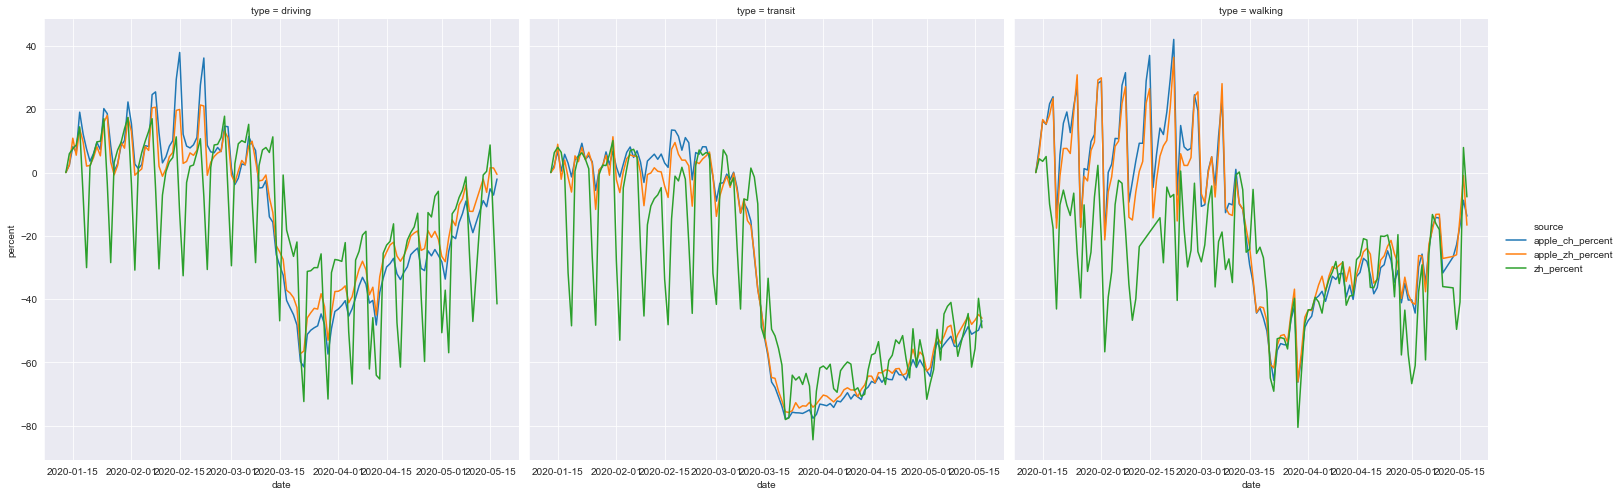

In [13]:
plot_data = (combination_df.melt(id_vars=["date","type","lockdown_flag"])
             .rename(columns={"variable":"source", "value": "percent"})
            )

sns.relplot(x="date",
            y="percent",
            hue="source",
            col="type",
            kind="line",
            data=plot_data,
            col_wrap=3,
            height=7)

In [19]:
(8.5*4)*.45/2

7.65

# Correlation

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9


In [20]:
(combination_df.groupby(["type","lockdown_flag"]).corr(method="pearson",)*100).style.format('{0:,.1f}')

In [22]:
(combination_df[combination_df.date > LOCKDOWN_DATE].drop(columns=["lockdown_flag"])
 .groupby("type")
 .corr(method="pearson"))

apple_ch_percent  apple_zh_percent  zh_percent
type                                                                    
driving apple_ch_percent          1.000000          0.995936    0.559999
        apple_zh_percent          0.995936          1.000000    0.580582
        zh_percent                0.559999          0.580582    1.000000
transit apple_ch_percent          1.000000          0.992482    0.720725
        apple_zh_percent          0.992482          1.000000    0.714096
        zh_percent                0.720725          0.714096    1.000000
walking apple_ch_percent          1.000000          0.982994    0.764823
        apple_zh_percent          0.982994          1.000000    0.779861
        zh_percent                0.764823          0.779861    1.000000

In [23]:
combination_df.corr(method="pearson")

,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
apple_ch_percent,1.000000,0.992285,0.802510,-0.852189
apple_zh_percent,0.992285,1.000000,0.827018,-0.815783
zh_percent,0.802510,0.827018,1.000000,-0.659017
lockdown_flag,-0.852189,-0.815783,-0.659017,1.000000


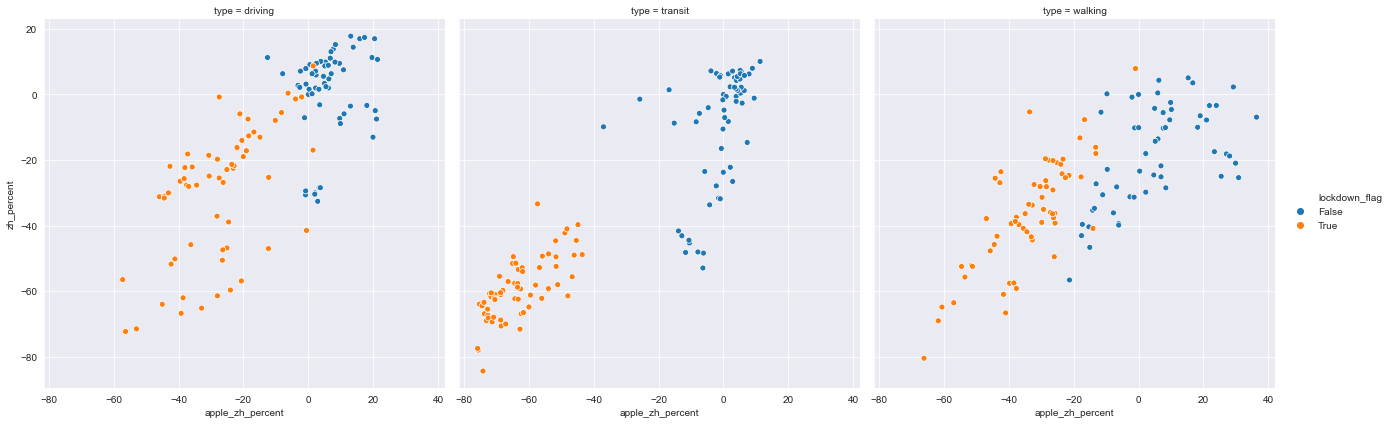

In [24]:
sns.relplot(x="apple_zh_percent",
            y="zh_percent",
            col="type",
            hue="lockdown_flag",
            data=combination_df,
            col_wrap=3,
            height=6)

False
True


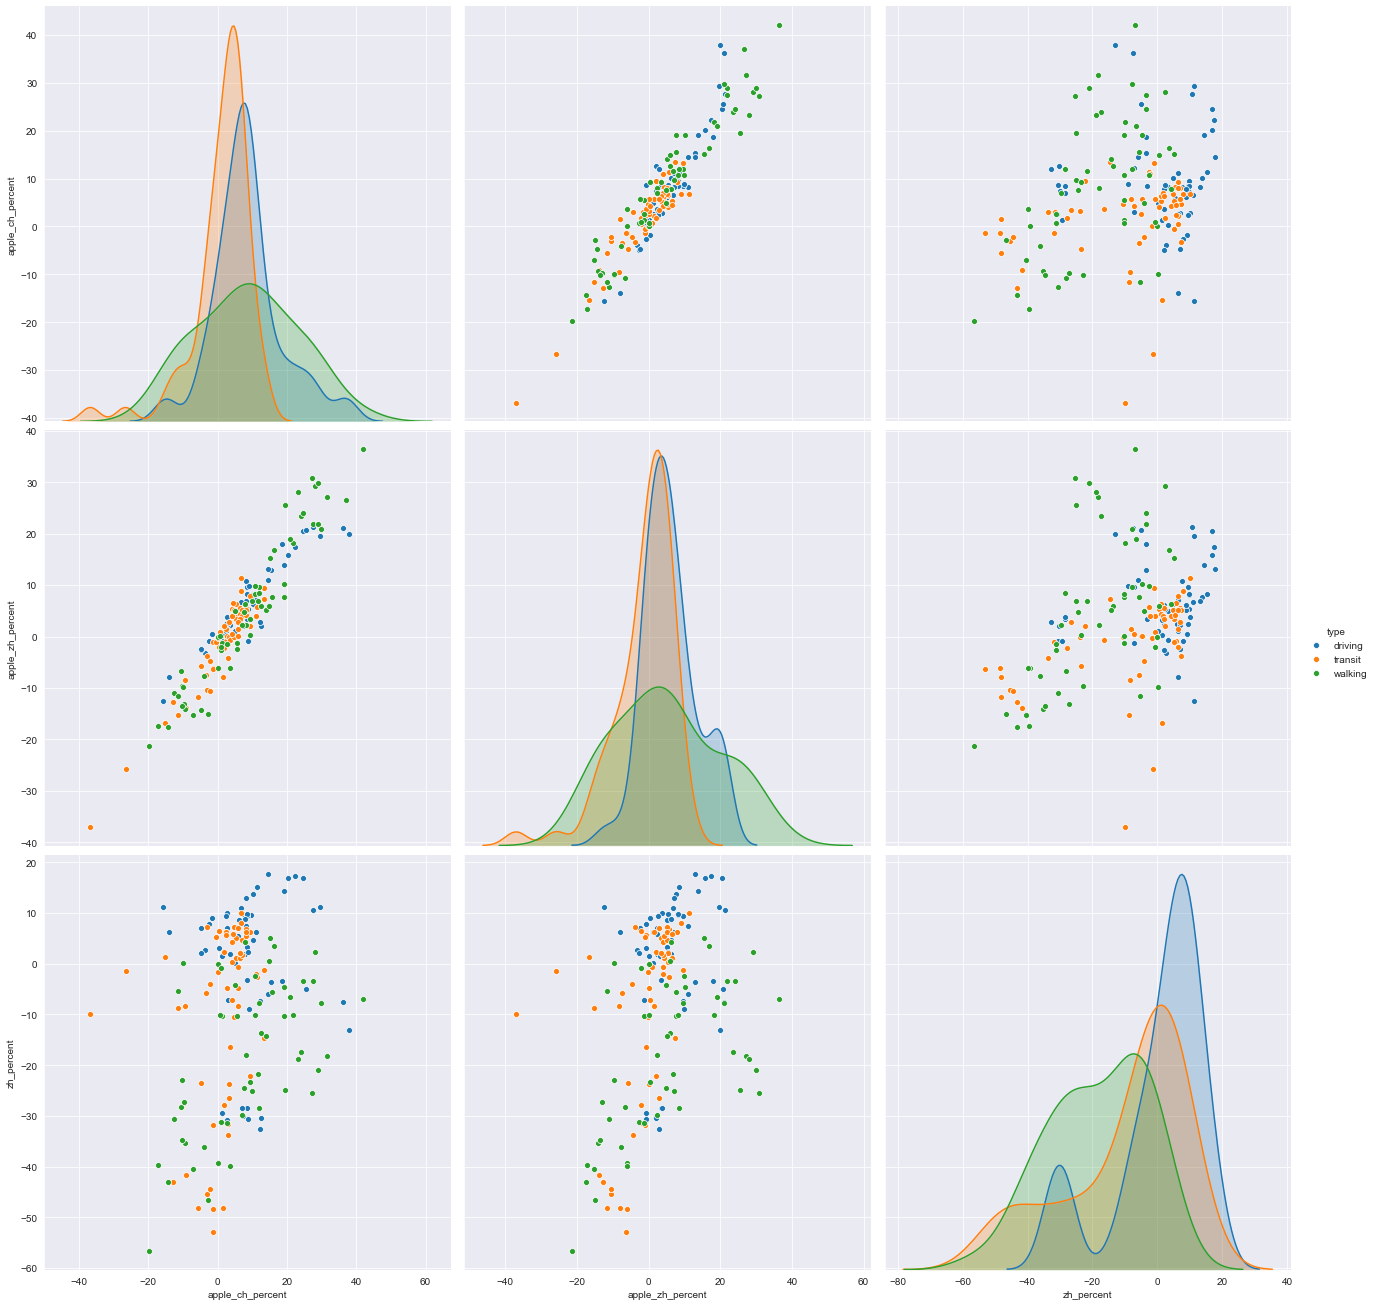

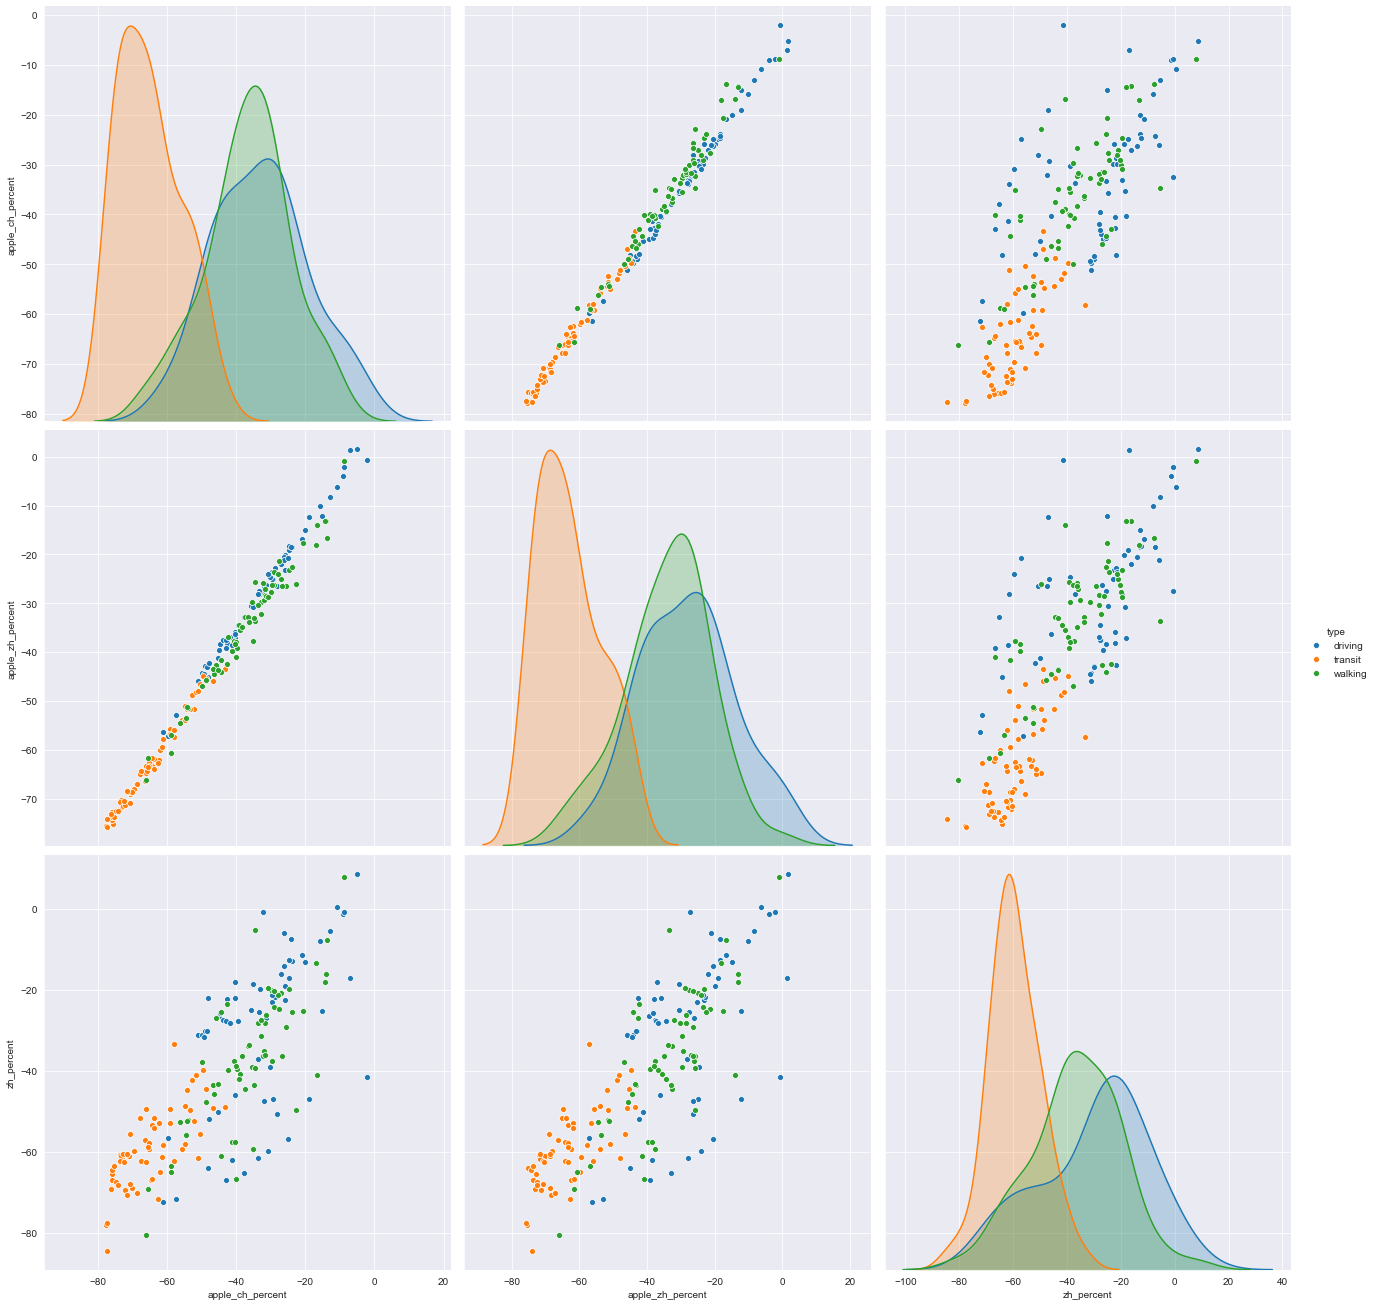

In [25]:
for flag,plot_data in combination_df.groupby("lockdown_flag"):
    print(flag)
    sns.pairplot(plot_data.drop(columns="lockdown_flag"),hue="type",height=6,)

# Seasonal Decomposition

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Additive Decomposition

In [287]:
combination_melted_df = (combination_df.melt(id_vars=["date","type","lockdown_flag"])
             .rename(columns={"variable":"source", "value": "percent"})
            ).sort_values("date")

grouped_dataset = combination_melted_df.groupby(["type","source"])

seasonal_decomposition_df = pd.DataFrame()
for x in grouped_dataset:
    temp_df = x[1].copy()
    temp_df.loc[:,"type"]= x[0][0]
    temp_df.loc[:,"source"] = x[0][1]

    observations = temp_df.percent
    observations_imputated = observations.fillna(observations.shift(7))
    
    result = seasonal_decompose(observations_imputated, model='additive', period=7,extrapolate_trend="freq")
    
    temp_df.loc[:,"trend"] = result.trend
    temp_df.loc[:,"seasonal"] = result.seasonal
    temp_df.loc[:,"residues"] = result.resid
    temp_df.loc[:,"trend_plus_seasonal"] = result.seasonal + result.trend
    
    seasonal_decomposition_df = pd.concat([seasonal_decomposition_df,temp_df])

In [288]:
seasonal_decomposition_df

,date,type,lockdown_flag,source,percent,trend,seasonal,residues,trend_plus_seasonal
0,2020-01-13,driving,False,apple_ch_percent,0.000000,7.054898,-3.618322,-3.436576,3.436576
3,2020-01-14,driving,False,apple_ch_percent,2.350000,7.392143,-2.577375,-2.464768,4.814768
6,2020-01-15,driving,False,apple_ch_percent,8.160000,7.729388,0.596114,-0.165502,8.325502
9,2020-01-16,driving,False,apple_ch_percent,6.470000,7.942857,-0.009064,-1.463793,7.933793
12,2020-01-17,driving,False,apple_ch_percent,19.060000,8.450000,6.143093,4.466907,14.593093
...,...,...,...,...,...,...,...,...,...
1103,2020-05-13,walking,True,zh_percent,-36.423366,-27.018393,-1.684886,-7.720087,-28.703279
1106,2020-05-14,walking,True,zh_percent,-49.534992,-25.815122,-4.755972,-18.963898,-30.571094
1109,2020-05-15,walking,True,zh_percent,-40.902287,-25.811529,3.203027,-18.293785,-22.608502
1112,2020-05-16,walking,True,zh_percent,7.895318,-25.111037,8.020590,24.985766,-17.090447


## Simple lineplot

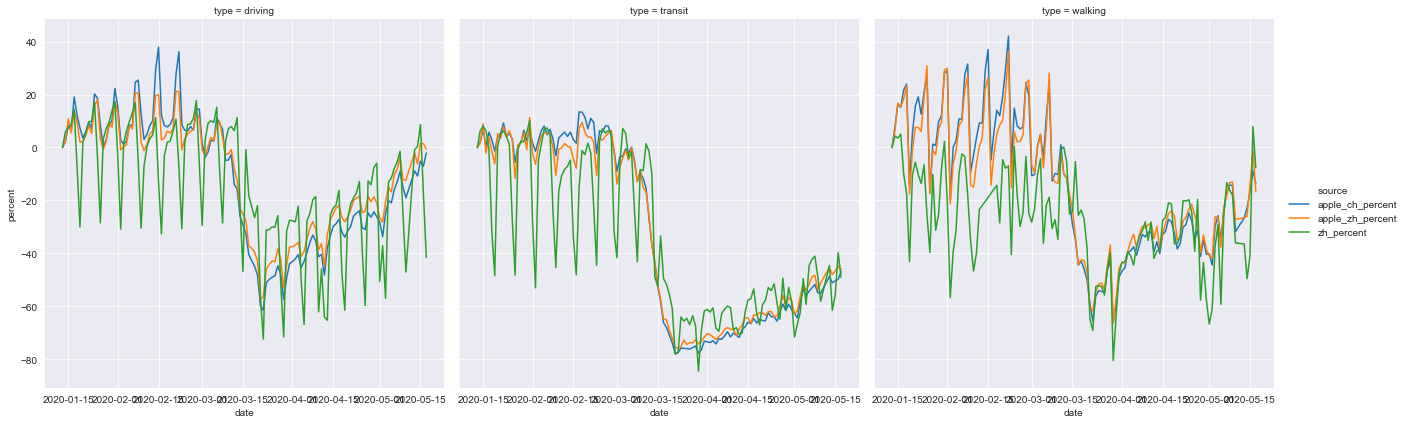

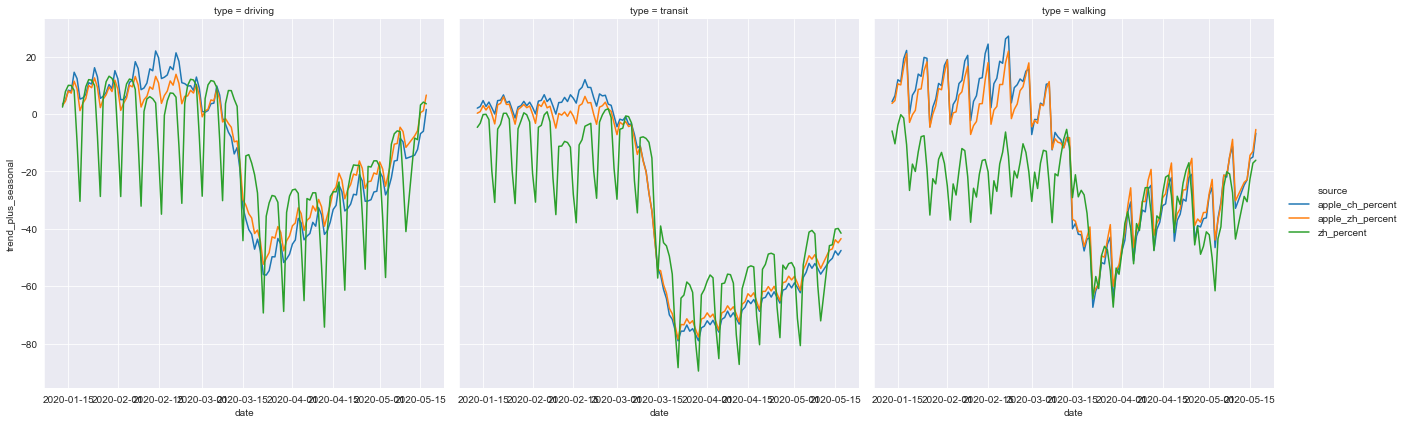

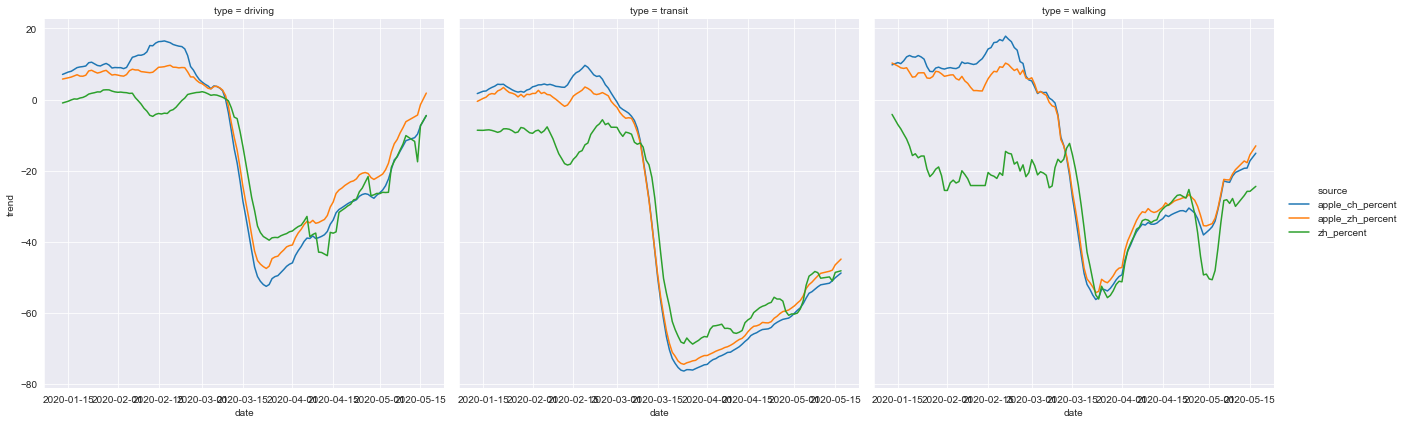

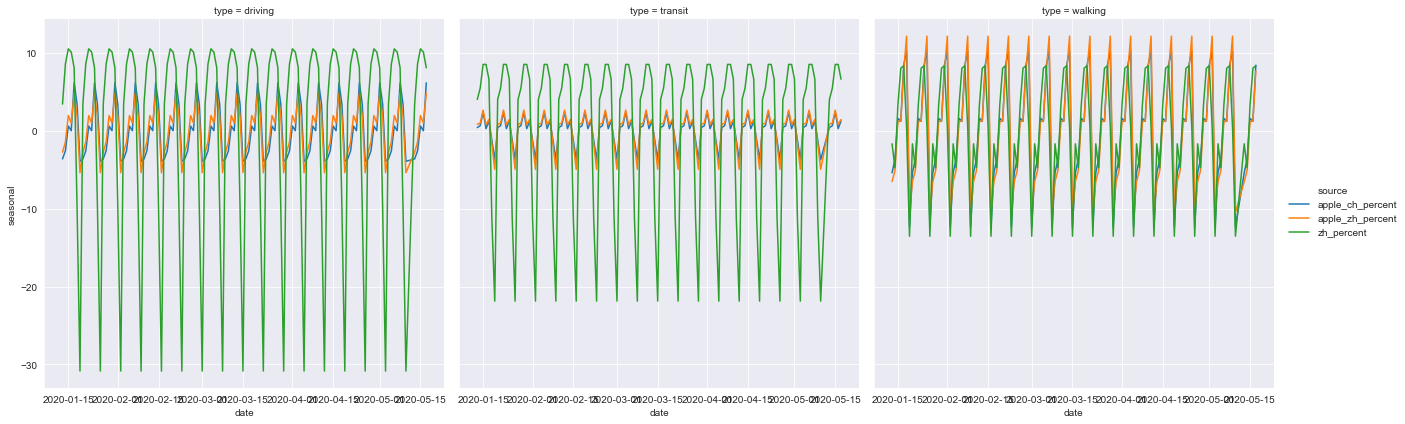

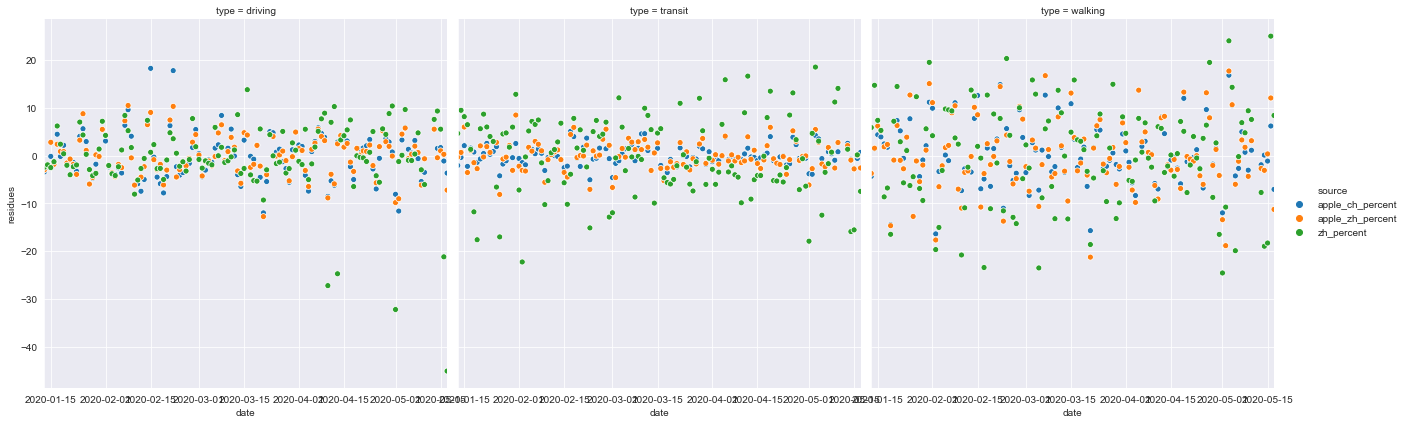

In [291]:
for y_values in ["percent","trend_plus_seasonal","trend","seasonal"]:
    sns.relplot(x="date",
            y=y_values,
            hue="source",
            col="type",
            kind="line",
            data=seasonal_decomposition_df,
            col_wrap=3,
            height=6)

g= sns.relplot(x="date",
            y="residues",
            hue="source",
            col="type",
            kind="scatter",
            data=seasonal_decomposition_df,
            col_wrap=3,
            height=6)
axes_ = g.axes
for x in [0,1,2]:
    axes_[x].set_xlim(seasonal_decomposition_df.date.min(),seasonal_decomposition_df.date.max())

## Correlation on Trend

In [292]:
correlate_this = (pd.pivot_table(seasonal_decomposition_df,
                values="trend",
                columns=["source"],
                index=['date', 'type', 'lockdown_flag'])
 .reset_index()
)

(correlate_this.drop(columns="lockdown_flag")
 .groupby("type")
 .corr(method="pearson")*100).style.format('{0:,.0f}')

# Granger Causality Test

- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html#statsmodels.tsa.stattools.grangercausalitytests

- https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [293]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [294]:
print("H0: apple_zh_percent does not granger-cause zh_percent")
for _type_ in ["driving", "transit", "walking"]:
    percent_changes_df = (correlate_this
              .loc[correlate_this.type == _type_,
                   ['zh_percent', 'apple_zh_percent']
                  ].pct_change().dropna()
             )
    percent_changes_df = percent_changes_df[percent_changes_df < np.inf].dropna()
    print(f"\n{_type_}: {(percent_changes_df.shape[0])} days")
    granger_result = grangercausalitytests(percent_changes_df,maxlag=1)

H0: apple_zh_percent does not granger-cause zh_percent

driving: 123 days

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5636  , p=0.0200  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=5.7038  , p=0.0169  , df=1
likelihood ratio test: chi2=5.5745  , p=0.0182  , df=1
parameter F test:         F=5.5636  , p=0.0200  , df_denom=119, df_num=1

transit: 123 days

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3770  , p=0.5404  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.3865  , p=0.5341  , df=1
likelihood ratio test: chi2=0.3859  , p=0.5344  , df=1
parameter F test:         F=0.3770  , p=0.5404  , df_denom=119, df_num=1

walking: 123 days

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3340  , p=0.5644  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.3424  , p=0.5584  , df=1
likelihood ratio test: chi2=0.3419  , p=0.5587  , df=1
parameter F test:         F=0.3340  , p=0.5644  , df_de

# Testing 

In [222]:
test = (pd.Series(range(0,7)) + 1).append((pd.Series(range(0,7)) + 1)).reset_index().drop(columns="index").copy()
test.loc[:,"shift"] = test.loc[:,0].shift(-1)
blah = grangercausalitytests(test.dropna(),maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=78434267280923841492946018893824.0000, p=0.0000  , df_denom=9, df_num=1
ssr based chi2 test:   chi2=104579023041231794662060861685760.0000, p=0.0000  , df=1
likelihood ratio test: chi2=854.9111, p=0.0000  , df=1
parameter F test:         F=78434267280923832485746764152832.0000, p=0.0000  , df_denom=9, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=611935419504898848755665600512.0000, p=0.0000  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=1923225604158253564871374274560.0000, p=0.0000  , df=2
likelihood ratio test: chi2=740.6703, p=0.0000  , df=2
parameter F test:         F=738354874630983768420542054400.0000, p=0.0000  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=418481685164504698401847246848.0000, p=0.0000  , df_denom=5, df_num=3
ssr based chi2 test:   chi2=2510890110987028753361036902400.0000, p=0.0000  , df=3
likelih